In [243]:
# Libraries, parameters

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from scipy.integrate import quad, dblquad
from scipy.interpolate import interp1d
from scipy.signal import fftconvolve

# Norms for the PMNS matrix squared:
u_e = [0, 0.674743, 0.302844, 0.0224125]
u_m = [0, 0.0946105, 0.360415, 0.544974]
u_t = [0, 0.230646, 0.33674,  0.432613]


# Effective distance traveled in 1oeV:
l_eff = 4.4434e23 * 5.06773093741 * 1e6

# Importing hypotheses and bin edges
hypotheses = pd.read_csv('hypotheses.csv')
bin_edges = pd.read_csv('bin_edges.csv')

# concatenating
frames = [bin_edges, hypotheses]
ngc_chart = pd.concat(frames, axis=1)

# Importing effective area data:
eff_a = np.loadtxt('effA_-5to30.dat')

# Limits of energy bins in the effective area data:
e_min = 1e-1
e_max = 7.94328e5

# More parameters:
phi0 = 5e-11 * 275270400 # TeV^-1 cm^-2 over 3168 days
e0 = 1 # TeV
index = 3.2 # Taken from NGC paper
width = 0.3 # In log10 scale, for track-like events

# del_m2
del_m2 = 0

base = 10


In [244]:
# Logspace Integral

def TrueIntegrandLog(log_e_true, log_e_reco, del_m2):

    exp_e_true = 10**(log_e_true)

    flux = (exp_e_true/e0)**(-index)

    log_gauss = norm.pdf(log_e_true, log_e_reco, width)
    
    # Finding the appropriate effective area for the given true energy
    x = eff_a[:,0]
    y = eff_a[:,4]
    f = interp1d(x, y)
    effa = 10000*f(exp_e_true) # cm^2, in data set as m^2

    # Calculating probability that the neutrino will be a muon neutrino (change e_true to eV): 
    osc = (np.cos((del_m2 * l_eff)/(4*exp_e_true*1e12)))**2
    prob_surv = osc * ((u_m[1]*u_m[1]) + (u_m[2]*u_m[2]) + (u_m[3]*u_m[3]))
    prob_emu = osc * ((u_e[1]*u_m[1]) + (u_e[2]*u_m[2]) + (u_e[3]*u_m[3]))
    prob_mu = 0.666666*prob_surv + 0.333333*prob_emu 
   
    log_integrand = log_gauss*flux*effa*prob_mu
    
    return log_integrand

def RecoIntegrandLog(e_reco, del_m2):
    log_e_reco = np.log10(e_reco)
    lower_bound = max(np.log10(e_min), log_e_reco-5*width)
    upper_bound = min(np.log10(e_max), log_e_reco+5*width) 
    true_int = quad(TrueIntegrandLog, lower_bound, upper_bound, args=(log_e_reco, del_m2), limit=50, epsabs=0.5)
    return 3*phi0*true_int[0]

def RecoIntLog(e_start, e_end, del_m2):
    return quad(RecoIntegrandLog, e_start, e_end, args=(del_m2, ), limit=20, epsabs=0.5)[0]

# Changing variables for both integrals into logspace
def NewIntegrand(log_e_true, log_e_reco, del_m2):
    return np.log(10)*np.power(10, log_e_reco)*TrueIntegrandLog(log_e_true, log_e_reco, del_m2)

def IntegralLog(e_start, e_end, del_m2):
    log_e_start = np.log10(e_start)
    log_e_end = np.log10(e_end)
    int = dblquad(NewIntegrand, log_e_start, log_e_end, lambda y: max(np.log10(e_min), y-5*width), lambda y: min(np.log10(e_max), y+5*width), args=(del_m2, ), epsabs=0.5)
    return 3*phi0*int[0]

# Versions without del_m2:
def TrueIntegrandLog1(log_e_true, log_e_reco):
    return TrueIntegrandLog(log_e_true, log_e_reco, del_m2)

def RecoIntegrandLog1(e_reco):
    return RecoIntegrandLog(e_reco, del_m2)

def RecoIntLog1(e_start, e_end):
    return RecoIntLog(e_start, e_end)

def NewIntegrand1(log_e_true, log_e_reco):
    return NewIntegrand(log_e_true, log_e_reco, del_m2)

def IntegralLog1(e_start, e_end):
    return IntegralLog(e_start, e_end, del_m2)


In [245]:
# Linspace Integral

def TrueIntegrandLin(e_true, e_reco, del_m2):

    flux = (e_true/e0)**(-index)

    log_gauss = norm.pdf(np.emath.log10(e_true), np.emath.log10(e_reco), width)
    
    # Finding the appropriate effective energy for the given true energy
    x = eff_a[:,0]
    y = eff_a[:,4]
    f = interp1d(x, y)
    effa = 10000*f(e_true) # cm^2, in data set as m^2

    # Calculating probability that the neutrino will be a muon neutrino (change e_true to eV): 
    osc = (np.cos((del_m2 * l_eff)/(4*e_true*1e12)))**2
    prob_surv = osc * ((u_m[1]*u_m[1]) + (u_m[2]*u_m[2]) + (u_m[3]*u_m[3]))
    prob_emu = osc * ((u_e[1]*u_m[1]) + (u_e[2]*u_m[2]) + (u_e[3]*u_m[3]))
    prob_mu = 0.666666*prob_surv + 0.333333*prob_emu 
   
    jacobian = (e_true*np.log(base))**(-1)
    log_integrand = jacobian*log_gauss*flux*effa*prob_mu
    
    return log_integrand

def RecoIntegrandLin(e_reco, del_m2):
    lower_bound = max(e_min, e_reco*np.power(10, -5*width))
    upper_bound = min(e_max, e_reco*np.power(10, 5*width))
    true_int = quad(TrueIntegrandLin, lower_bound, upper_bound, args=(e_reco, del_m2), limit=50, epsabs=0.5)
    return 3*phi0*true_int[0]

def RecoIntLin(e_start, e_end, del_m2):
    return quad(RecoIntegrandLin, e_start, e_end, args=(del_m2, ), limit=20, epsabs=0.5)[0]

def IntegralLin(e_start, e_end, del_m2):
    int = dblquad(TrueIntegrandLin, e_start, e_end, lambda y: max(e_min, y*np.power(10, -5*width)), lambda y: min(e_max, y*np.power(10, 5*width)), args=(del_m2, ), epsabs=0.5)
    return 3*phi0*int[0]


# Versions without del_m2:
def TrueIntegrandLin1(log_e_true, log_e_reco):
    return TrueIntegrandLin(log_e_true, log_e_reco, del_m2)

def RecoIntegrandLin1(e_reco):
    return RecoIntegrandLin(e_reco, del_m2)

def RecoIntLin1(e_start, e_end):
    return RecoIntLin(e_start, e_end)

def IntegralLin1(e_start, e_end):
    return IntegralLin(e_start, e_end, del_m2)

In [246]:
# sigma = 0:

def NoGaussRecoIntegrand(e_reco, del_m2):

    flux = 3*phi0*(e_reco/e0)**(-index)

    # Finding the appropriate effective energy for the given true energy
    x = eff_a[:,0]
    y = eff_a[:,4]
    f = interp1d(x, y)
    effa = 10000*f(e_reco) # cm^2, in data set as m^2

    # Calculating probability that the neutrino will be a muon neutrino (change e_true to eV): 
    osc = (np.cos((del_m2 * l_eff)/(4*e_reco*1e12)))**2
    prob_surv = osc * ((u_m[1]*u_m[1]) + (u_m[2]*u_m[2]) + (u_m[3]*u_m[3]))
    prob_emu = osc * ((u_e[1]*u_m[1]) + (u_e[2]*u_m[2]) + (u_e[3]*u_m[3]))
    prob_mu = 0.666666*prob_surv + 0.333333*prob_emu 

    integrand = flux*effa*prob_mu

    return integrand

def NoGaussIntegral(e_start, e_end, del_m2):
    return quad(NoGaussRecoIntegrand, e_start, e_end, del_m2)[0]

In [247]:
nogauss_int = []
int_approx_001 = []
for i in range(len(ngc_chart['energy']) - 1):
    e_t = ngc_chart['energy'][i]
    e_t_next = ngc_chart['energy'][i+1]
    nogauss_int.append(NoGaussRecoIntegrand(e_t, 0)*(e_t_next - e_t))
    int_approx_001.append(RecoIntegrandLin(e_t, 0)*(e_t_next - e_t))
nogauss_int.append(0)
int_approx_001.append(0)

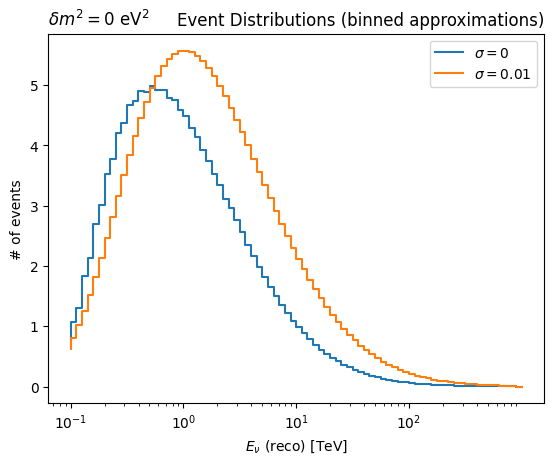

In [248]:
# Comparing no Gaussian to Gaussian

fig, ax = plt.subplots()
# null, = ax.step(ngc_chart['energy'], ngc_chart['null'])
sig0, = ax.step(ngc_chart['energy'], nogauss_int)
sig001, = ax.step(ngc_chart['energy'], int_approx_001)
ax.set_xscale('log')
ax.set_xticks([10**-1, 10**0, 10**1, 10**2])
ax.set_xlabel(r"$E_{\nu}$ (reco) [TeV]")
ax.set_ylabel(r"# of events")
ax.set_title(r"$\delta m^2 = 0$ eV$^2$", loc="left")
ax.set_title(r"Event Distributions (binned approximations)", loc="right")
ax.legend([sig0, sig001], [r"$\sigma = 0$", r"$\sigma = 0.01$"])
plt.show()

In [249]:
# Test on one bin (log):
e_start = 1
e_end =1.122
del_m2 = 0

iterated_double_log = RecoIntLog(e_start, e_end, del_m2)
double_log = IntegralLog(e_start, e_end, del_m2)

print(iterated_double_log)
print(double_log)

KeyboardInterrupt: 

In [ ]:
# Test on one bin (lin):
e_start = 1
e_end = 1.122
del_m2 = 0

iterated_double_lin = RecoIntLin(e_start, e_end, del_m2)
double_lin = IntegralLin(e_start, e_end, del_m2)

print(iterated_double_lin)
print(double_lin)


5.256710102704203
5.256710102704203


In [ ]:
# Approximation for sigma = 0.3

int_approx_lin03 = []
for i in range(len(ngc_chart['energy']) - 1):
    e_t = ngc_chart['energy'][i]
    e_t_next = ngc_chart['energy'][i+1]
    int_approx_lin03.append(RecoIntegrandLin(e_t, 0)*(e_t_next-e_t))
int_approx_lin03.append(0)

In [ ]:
# Double Integral (noniterated) Test
int_lin = []
int_log = []
for i in range(len(ngc_chart['energy']) - 1):
    e_t = ngc_chart['energy'][i]
    e_t_next = ngc_chart['energy'][i+1]
    int_lin.append(IntegralLin(e_t, e_t_next, 0))
    int_log.append(IntegralLog(e_t, e_t_next, 0))
int_lin.append(0)
int_log.append(0)


"\nint_lin = []\nint_log = []\nfor i in range(len(ngc_chart['energy']) - 1):\n    e_t = ngc_chart['energy'][i]\n    e_t_next = ngc_chart['energy'][i+1]\n    int_lin.append(IntegralLin(e_t, e_t_next, 0))\n    int_log.append(IntegralLog(e_t, e_t_next, 0))\nint_lin.append(0)\nint_log.append(0)\n"

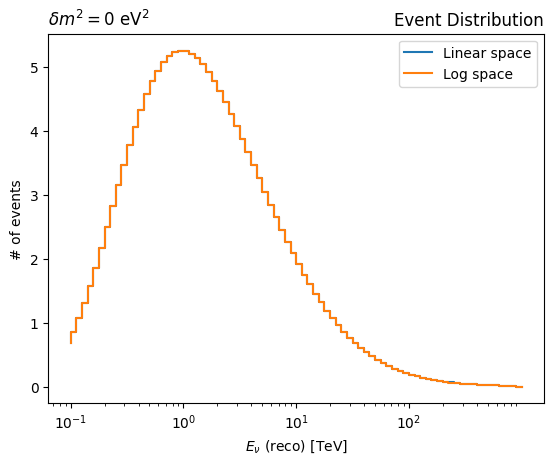

In [ ]:
# Plots

fig, ax = plt.subplots()
# null, = ax.step(ngc_chart['energy'], ngc_chart['null'])
lin, = ax.step(ngc_chart['energy'], int_lin)
log, = ax.step(ngc_chart['energy'], int_log)
# lin_approx, = ax.step(ngc_chart['energy'], int_approx_lin03)
ax.set_xscale('log')
ax.set_xticks([10**-1, 10**0, 10**1, 10**2])
ax.set_xlabel(r"$E_{\nu}$ (reco) [TeV]")
ax.set_ylabel(r"# of events")
ax.set_title(r"$\delta m^2 = 0$ eV$^2$", loc="left")
ax.set_title(r"Event Distribution", loc="right")
ax.legend([lin, log], [r"Linear space", r"Log space"])
plt.show()

In [250]:
# FFT Convolution Alg

def F(log_e_reco):

    exp_e_reco = 10**(log_e_reco)

    flux = 3*phi0*(exp_e_reco/e0)**(-index)

    x = eff_a[:,0]
    y = eff_a[:,4]
    f = interp1d(x, y)
    effa = 10000*f(exp_e_reco)

    osc = (np.cos((del_m2 * l_eff)/(4*exp_e_reco*1e12)))**2
    prob_surv = osc * ((u_m[1]*u_m[1]) + (u_m[2]*u_m[2]) + (u_m[3]*u_m[3]))
    prob_emu = osc * ((u_e[1]*u_m[1]) + (u_e[2]*u_m[2]) + (u_e[3]*u_m[3]))
    prob_mu = 0.666666*prob_surv + 0.333333*prob_emu 

    fx = flux*effa*prob_mu

    return fx


def G(log_e_reco):
    return (1/(width*np.sqrt(2*np.pi)))*np.exp(-0.5*((log_e_reco)/width)**2)

In [273]:
# Discretizing the integrand

num_bins = 10000
a = np.linspace(-1, 3, num_bins)

F_sample = []
for i in range(num_bins):
    F_sample.append(F(a[i]))

G_sample = []
for i in range(num_bins):
    G_sample.append(G(a[i]))

H = []
for i in range(int(num_bins/2)):
    H.append(0)
G_sample = H+G_sample

In [274]:
# Convoluting the integrand

convolution = fftconvolve(F_sample, G_sample, mode='same')*(a[1]-a[0])

b = np.linspace(-1, 3, len(convolution))

FG = interp1d(b, convolution)

In [275]:
# Taking the outside integrand (FFTconv alg)

def NewIntegrand(log_e_reco):
    return np.log(10)*np.power(10, log_e_reco)*FG(log_e_reco)

def FFTIntegral(log_e_start, log_e_end):
    return quad(NewIntegrand, log_e_start, log_e_end, limit=50, epsabs=0.5)[0]

In [276]:
int_FFT = []
for i in range(len(ngc_chart['energy']) - 1):
    e_t = np.log10(ngc_chart['energy'][i])
    e_t_next = np.log10(ngc_chart['energy'][i+1])
    int_FFT.append(FFTIntegral(e_t, e_t_next))
int_FFT.append(0)

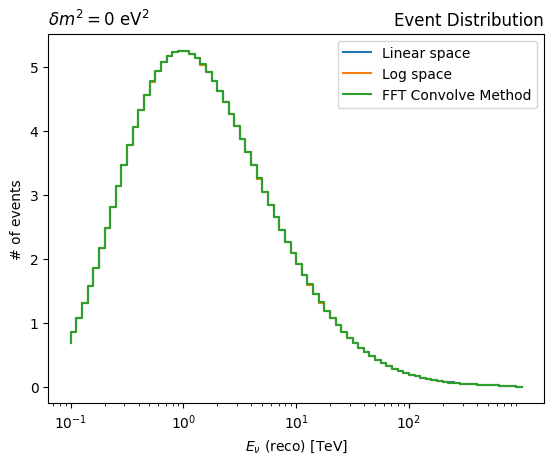

In [ ]:
# Plots (FFT vs quad)

fig, ax = plt.subplots()
# null, = ax.step(ngc_chart['energy'], ngc_chart['null'])
lin, = ax.step(ngc_chart['energy'], int_lin)
log, = ax.step(ngc_chart['energy'], int_log)
FFT, = ax.step(ngc_chart['energy'], int_FFT)
ax.set_xscale('log')
ax.set_xticks([10**-1, 10**0, 10**1, 10**2])
ax.set_xlabel(r"$E_{\nu}$ (reco) [TeV]")
ax.set_ylabel(r"# of events")
ax.set_title(r"$\delta m^2 = 0$ eV$^2$", loc="left")
ax.set_title(r"Event Distribution", loc="right")
ax.legend([lin, log, FFT], [r"Linear space", r"Log space", r"FFT Convolve Method"])
plt.show()

In [277]:
residual100 = []
for i in range(len(ngc_chart['energy']) - 1):
    residual100.append(int_FFT[i] - int_log[i])
residual100.append(0)

In [278]:
residual1000 = []
for i in range(len(ngc_chart['energy']) - 1):
    residual1000.append(int_FFT[i] - int_log[i])
residual1000.append(0)

In [287]:
residual10000 = []
for i in range(len(ngc_chart['energy']) - 1):
    residual10000.append(int_FFT[i] - int_log[i])
residual10000.append(0)

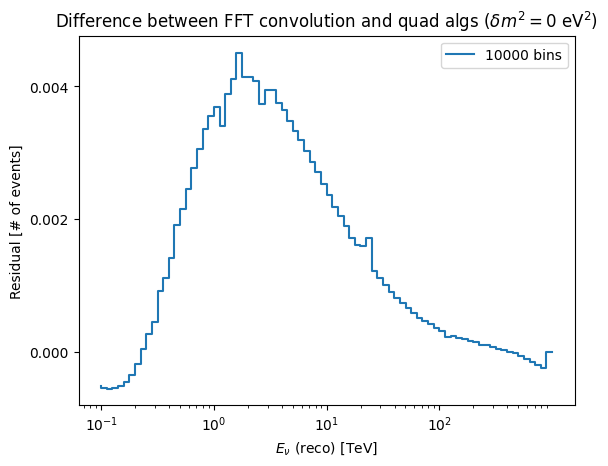

In [289]:
# Residual (FFTconvolve vs quad algs):

fig, ax = plt.subplots()
# residual100, = ax.step(ngc_chart['energy'], residual100)
# residual1000, = ax.step(ngc_chart['energy'], residual1000)
residual10000, = ax.step(ngc_chart['energy'], residual10000)
ax.set_xscale('log')
ax.set_xticks([10**-1, 10**0, 10**1, 10**2])
ax.set_yticks([0, 2*10**(-3), 4*10**(-3)])
ax.set_xlabel(r"$E_{\nu}$ (reco) [TeV]")
ax.set_ylabel(r"Residual [# of events]")
ax.set_title(r"Difference between FFT convolution and quad algs ($\delta m^2 = 0$ eV$^2$)")
ax.legend([residual10000], [r"10000 bins"])
plt.show()

In [ ]:
# Just inner int (FFTconv alg)


num_bins = 100
energy = np.logspace(-1, 3, num_bins)

test_arrayFFT = []
for i in range(num_bins):
    test_arrayFFT.append(FG(np.log10(energy[i])))

In [ ]:
# Just inner int (quad)

test_array = []
for i in range(num_bins):
    test_array.append(RecoIntegrandLog(energy[i], 0))


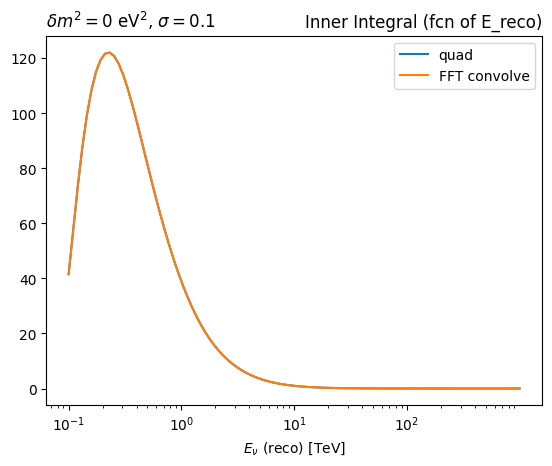

In [ ]:
# Plots (just inner int, FFTconv vs quad algs)

fig, ax = plt.subplots()
# null, = ax.step(ngc_chart['energy'], ngc_chart['null'])
test, = ax.plot(energy, test_array)
testFFT, = ax.plot(energy, test_arrayFFT)
ax.set_xscale('log')
ax.set_xticks([10**-1, 10**0, 10**1, 10**2])
ax.set_xlabel(r"$E_{\nu}$ (reco) [TeV]")
# ax.set_ylabel(r"# of events")
ax.set_title(r"$\delta m^2 = 0$ eV$^2$, $\sigma = 0.1$", loc="left")
ax.set_title(r"Inner Integral (fcn of E_reco)", loc="right")
ax.legend([test, testFFT], [r"quad", r"FFT convolve"])